In [ ]:
import numpy as mp
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import random
import time

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Participants_Data_WH18/Train.csv")
# print(df.sum())
# print(df.shape)
df_train=df[df.Class==0].sample(1410) # 80% data
index_list=df_train.index
df=df.drop(index_list)
df_train=df_train.drop('Class',axis=1)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1024, use_bias=False, input_shape=(128,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1024))
    #assert model.output_shape == (None,16 ) # Note: None is the batch size

    model.add(layers.Dense(1800))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1800))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1558))
    assert model.output_shape == (None,1558 )


    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=False,
                                    input_shape=[None,1558]))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512, use_bias=True))

    model.add(layers.Dense(128, use_bias=True))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    model.add(layers.Dense(1))
    #model.add(layers.Softmax())

    return model

In [ ]:
generator=make_generator_model()
discriminator=make_discriminator_model()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 150
noise_dim = 128
BATCH_SIZE = 64

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    images=tf.reshape(images,(1,1558))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss,disc_loss)

In [ ]:
history=dict()
history['gen']=[]
history['dis']=[]
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:

           gen_loss,dis_loss= train_step(batch)
        history['gen'].append(gen_loss)
        history['dis'].append(dis_loss)
        print ('Time for epoch {} is {} sec '.format(epoch + 1, time.time()-start))

In [ ]:
x_train=df_train.values
train(x_train,EPOCHS)

Time for epoch 1 is 20.108516693115234 sec 
Time for epoch 2 is 7.542027235031128 sec 
Time for epoch 3 is 8.378647089004517 sec 
Time for epoch 4 is 7.5319719314575195 sec 
Time for epoch 5 is 8.460922956466675 sec 
Time for epoch 6 is 7.989041090011597 sec 
Time for epoch 7 is 8.959397315979004 sec 
Time for epoch 8 is 7.575645208358765 sec 
Time for epoch 9 is 8.341313362121582 sec 
Time for epoch 10 is 7.561894655227661 sec 
Time for epoch 11 is 8.818543434143066 sec 
Time for epoch 12 is 7.7844579219818115 sec 
Time for epoch 13 is 8.320334672927856 sec 
Time for epoch 14 is 7.792107105255127 sec 
Time for epoch 15 is 8.166926383972168 sec 
Time for epoch 16 is 7.896190404891968 sec 
Time for epoch 17 is 8.046820878982544 sec 
Time for epoch 18 is 7.895363092422485 sec 
Time for epoch 19 is 8.501338243484497 sec 
Time for epoch 20 is 8.003499269485474 sec 
Time for epoch 21 is 7.586004018783569 sec 
Time for epoch 22 is 8.216012477874756 sec 
Time for epoch 23 is 7.492152214050293

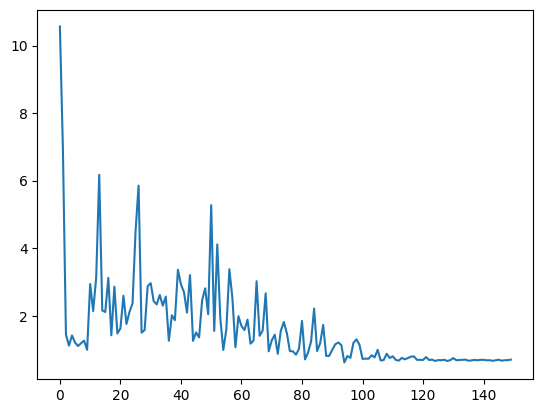

In [ ]:
plt.plot(history['gen'])

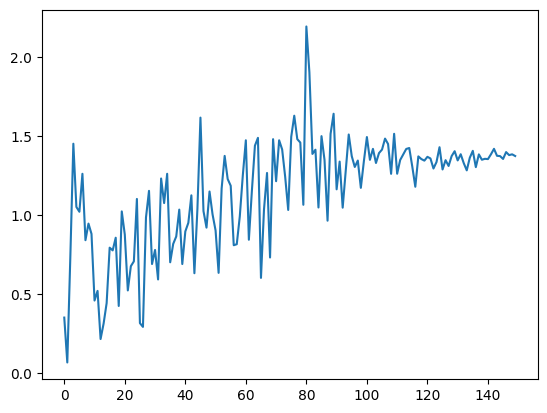

In [ ]:
plt.plot(history['dis'])

In [ ]:
y_test=df.Class
x_test=df.drop('Class',axis=1).values.reshape(-1,1,1558)
y_pred=discriminator.predict(x_test)

12/12 [==============================] - 0s 3ms/step


Text(0, 0.5, 'y_pred')

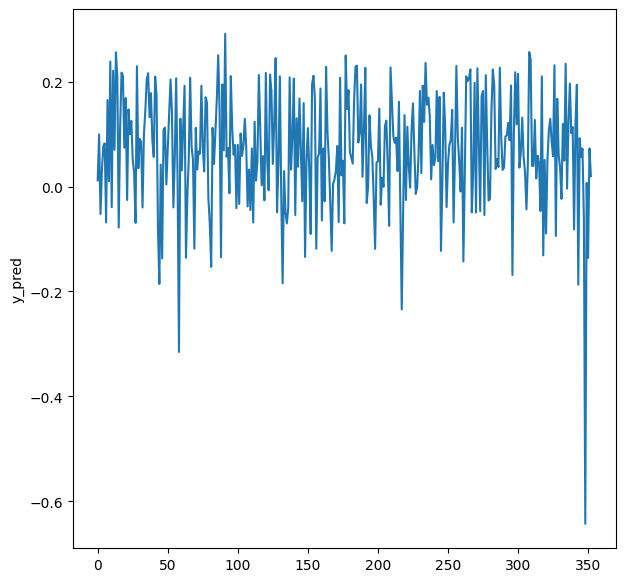

In [ ]:
from sklearn.metrics import average_precision_score, accuracy_score ,recall_score, f1_score
plt.figure(figsize=(7,7))
plt.plot(range(len(y_pred)),y_pred.reshape(-1,1))
plt.ylabel('y_pred')

In [ ]:
prob=[-0.2,-0.1,-0.05,0,0.005,0.1]
for p in prob:
    pred_value =[1 if i<p   else 0 for i in y_pred]
    f1=f1_score(y_test,pred_value)
    acc=accuracy_score(y_test,pred_value)
    precision=average_precision_score(y_test,pred_value)
    recall= recall_score(y_test,pred_value)
    print(f'prob ={p} and f1 score ={f1} : accuracy={acc} : precision={precision} : recall={recall}')
    print(pred_value.count(0),pred_value.count(1))

prob =-0.2 and f1 score =0.027397260273972605 : accuracy=0.5977337110481586 : precision=0.408757437086049 : recall=0.013986013986013986
350 3
prob =-0.1 and f1 score =0.147239263803681 : accuracy=0.6062322946175638 : precision=0.42145446621367294 : recall=0.08391608391608392
333 20
prob =-0.05 and f1 score =0.2391304347826087 : accuracy=0.603399433427762 : precision=0.42532779871272236 : recall=0.15384615384615385
312 41
prob =0 and f1 score =0.27678571428571425 : accuracy=0.5410764872521246 : precision=0.40024686955753996 : recall=0.21678321678321677
272 81
prob =0.005 and f1 score =0.2719298245614035 : accuracy=0.5297450424929179 : precision=0.39634256761402237 : recall=0.21678321678321677
268 85
prob =0.1 and f1 score =0.3231197771587744 : accuracy=0.311614730878187 : precision=0.3497028100427534 : recall=0.40559440559440557
137 216


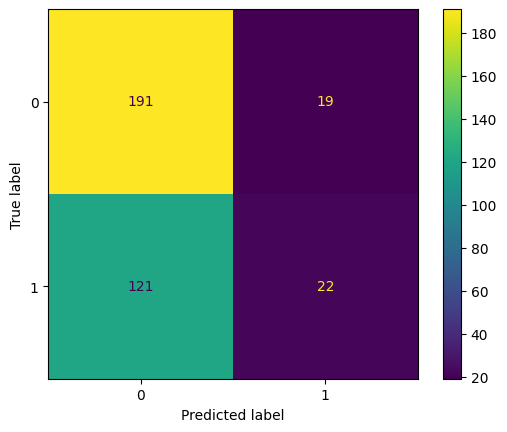

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pred_value =[1 if i<-0.05 else 0 for i in y_pred]
con_mat = confusion_matrix(y_test, pred_value)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()